# Data 603 Final Project

In [51]:
## Import Important Libraries
import ast
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder.appName("MLExample").getOrCreate()

In [3]:
file_path = "C:\\Users\\aksha\\Downloads\\India Agriculture Crop Production.csv\\India Agriculture Crop Production.csv"

# Read the CSV file into a PySpark DataFrame
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Show the first few rows of the DataFrame
df.show(5)


+--------------------+--------------------+--------+-------+----------+------+----------+----------+----------------+------------------+
|               State|            District|    Crop|   Year|    Season|  Area|Area Units|Production|Production Units|             Yield|
+--------------------+--------------------+--------+-------+----------+------+----------+----------+----------------+------------------+
|Andaman and Nicob...|            NICOBARS|Arecanut|2001-02|    Kharif|1254.0|   Hectare|    2061.0|          Tonnes|1.6435406698564594|
|Andaman and Nicob...|            NICOBARS|Arecanut|2002-03|Whole Year|1258.0|   Hectare|    2083.0|          Tonnes|1.6558028616852147|
|Andaman and Nicob...|            NICOBARS|Arecanut|2003-04|Whole Year|1261.0|   Hectare|    1525.0|          Tonnes|1.2093576526566217|
|Andaman and Nicob...|NORTH AND MIDDLE ...|Arecanut|2001-02|    Kharif|3100.0|   Hectare|    5239.0|          Tonnes|              1.69|
|Andaman and Nicob...|      SOUTH ANDAMAN

## Data Cleaning

In [4]:
# Import necessary functions
from pyspark.sql.functions import count, when, col

# Check for missing values in the DataFrame
missing_values = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])

# Show the count of missing values
missing_values.show()


+-----+--------+----+----+------+----+----------+----------+----------------+-----+
|State|District|Crop|Year|Season|Area|Area Units|Production|Production Units|Yield|
+-----+--------+----+----+------+----+----------+----------+----------------+-----+
|    0|       0|  32|   0|     0|  33|         0|      4993|               0|   33|
+-----+--------+----+----+------+----+----------+----------+----------------+-----+



In [5]:
# Remove rows with missing values
df_cleaned = df.na.drop()

# Check for missing values in the cleaned DataFrame
missing_values_cleaned = df_cleaned.select([count(when(col(c).isNull(), c)).alias(c) for c in df_cleaned.columns])

# Show the count of missing values in the cleaned DataFrame
missing_values_cleaned.show()

+-----+--------+----+----+------+----+----------+----------+----------------+-----+
|State|District|Crop|Year|Season|Area|Area Units|Production|Production Units|Yield|
+-----+--------+----+----+------+----+----------+----------+----------------+-----+
|    0|       0|   0|   0|     0|   0|         0|         0|               0|    0|
+-----+--------+----+----+------+----+----------+----------+----------------+-----+



In [6]:
# Number of rows
num_rows = df_cleaned.count()

# Number of columns
num_columns = len(df.columns)

print("Number of rows: ", num_rows)
print("Number of columns: ", num_columns)

Number of rows:  340414
Number of columns:  10


In [7]:
# Print the columns of the DataFrame
print("Columns: {}".format(df_cleaned.columns))

Columns: ['State', 'District', 'Crop', 'Year', 'Season', 'Area', 'Area Units', 'Production', 'Production Units', 'Yield']


## Exploratory Data Analysis

In [8]:


# Find distinct states
distinct_states = df_cleaned.select("State").distinct()

# Find distinct crops
distinct_crops = df_cleaned.select("Crop").distinct()

# Find distinct seasons
distinct_seasons = df_cleaned.select("Season").distinct()

# Show the results
print("Distinct States:")
distinct_states.show(truncate=False)

print("Distinct Crops:")
distinct_crops.show(truncate=False)

print("Distinct Seasons:")
distinct_seasons.show(truncate=False)



Distinct States:
+----------------------+
|State                 |
+----------------------+
|Nagaland              |
|Karnataka             |
|Odisha                |
|Kerala                |
|Tamil Nadu            |
|Chhattisgarh          |
|Andhra Pradesh        |
|Madhya Pradesh        |
|Punjab                |
|Manipur               |
|Goa                   |
|Mizoram               |
|Dadra and Nagar Haveli|
|Himachal Pradesh      |
|Puducherry            |
|Haryana               |
|Jammu and Kashmir     |
|Jharkhand             |
|Arunachal Pradesh     |
|Gujarat               |
+----------------------+
only showing top 20 rows

Distinct Crops:
+-----------------+
|Crop             |
+-----------------+
|Arecanut         |
|Black pepper     |
|Sesamum          |
|Safflower        |
|Urad             |
|Banana           |
|Maize            |
|Bajra            |
|Cardamom         |
|Cashewnut        |
|Coconut          |
|Cotton(lint)     |
|Rapeseed &Mustard|
|Other Rabi pulses|
|

In [9]:
# Find distinct area units
distinct_area_units = df_cleaned.select("Area Units").distinct()

# Find distinct production units
distinct_production_units = df_cleaned.select("Production Units").distinct()

# Show the results
print("Distinct Area Units:")
distinct_area_units.show(truncate=False)

print("Distinct Production Units:")
distinct_production_units.show(truncate=False)

Distinct Area Units:
+----------+
|Area Units|
+----------+
|Hectare   |
+----------+

Distinct Production Units:
+----------------+
|Production Units|
+----------------+
|Tonnes          |
|Bales           |
|Nuts            |
+----------------+



In [10]:
from pyspark.sql.functions import col, lit, when


# Define conversion factors for each production unit
conversion_factors = {'Tonnes': 1, 'Nuts': 1/50, 'Bales': 1.7}

# Add a new column 'Production_Tonnes' using the conversion factors
df_cleaned = df_cleaned.withColumn("Production_Tonnes", 
                  when(col("Production Units") == "Tonnes", col("Production"))
                  .when(col("Production Units") == "Nuts", col("Production") * conversion_factors["Nuts"])
                  .when(col("Production Units") == "Bales", col("Production") * conversion_factors["Bales"])
                  .otherwise(lit(None)))  # Handle other units or set to None if not in conversion_factors

# Print the DataFrame with the new 'Production_Tonnes' column
df_cleaned.select("Production", "Production Units", "Production_Tonnes").show(truncate=False)


+----------+----------------+-----------------+
|Production|Production Units|Production_Tonnes|
+----------+----------------+-----------------+
|2061.0    |Tonnes          |2061.0           |
|2083.0    |Tonnes          |2083.0           |
|1525.0    |Tonnes          |1525.0           |
|5239.0    |Tonnes          |5239.0           |
|5267.0    |Tonnes          |5267.0           |
|5182.0    |Tonnes          |5182.0           |
|1278.0    |Tonnes          |1278.0           |
|1763.0    |Tonnes          |1763.0           |
|10882.0   |Tonnes          |10882.0          |
|11558.0   |Tonnes          |11558.0          |
|13.5      |Tonnes          |13.5             |
|15.86     |Tonnes          |15.86            |
|102.5     |Tonnes          |102.5            |
|104.37    |Tonnes          |104.37           |
|192.0     |Tonnes          |192.0            |
|208.0     |Tonnes          |208.0            |
|208.5     |Tonnes          |208.5            |
|33.0      |Tonnes          |33.0       

In [11]:
# Show the entire DataFrame with the new 'Production_Tonnes' column
df_cleaned.show()

+--------------------+--------------------+------------+-------+----------+------+----------+----------+----------------+-------------------+-----------------+
|               State|            District|        Crop|   Year|    Season|  Area|Area Units|Production|Production Units|              Yield|Production_Tonnes|
+--------------------+--------------------+------------+-------+----------+------+----------+----------+----------------+-------------------+-----------------+
|Andaman and Nicob...|            NICOBARS|    Arecanut|2001-02|    Kharif|1254.0|   Hectare|    2061.0|          Tonnes| 1.6435406698564594|           2061.0|
|Andaman and Nicob...|            NICOBARS|    Arecanut|2002-03|Whole Year|1258.0|   Hectare|    2083.0|          Tonnes| 1.6558028616852147|           2083.0|
|Andaman and Nicob...|            NICOBARS|    Arecanut|2003-04|Whole Year|1261.0|   Hectare|    1525.0|          Tonnes| 1.2093576526566217|           1525.0|
|Andaman and Nicob...|NORTH AND MIDDLE .

In [12]:
# Create the new column 'yield_per_hectare'
df_cleaned = df_cleaned.withColumn("yield_per_hectare", col("Production_Tonnes") / col("Area"))

# Show the entire DataFrame with the new 'yield_per_hectare' column
df_cleaned.show(truncate=False)

+---------------------------+------------------------+------------+-------+----------+------+----------+----------+----------------+-------------------+-----------------+-------------------+
|State                      |District                |Crop        |Year   |Season    |Area  |Area Units|Production|Production Units|Yield              |Production_Tonnes|yield_per_hectare  |
+---------------------------+------------------------+------------+-------+----------+------+----------+----------+----------------+-------------------+-----------------+-------------------+
|Andaman and Nicobar Islands|NICOBARS                |Arecanut    |2001-02|Kharif    |1254.0|Hectare   |2061.0    |Tonnes          |1.6435406698564594 |2061.0           |1.6435406698564594 |
|Andaman and Nicobar Islands|NICOBARS                |Arecanut    |2002-03|Whole Year|1258.0|Hectare   |2083.0    |Tonnes          |1.6558028616852147 |2083.0           |1.6558028616852147 |
|Andaman and Nicobar Islands|NICOBARS        

In [13]:
# List of columns to drop
columns_to_drop = ['Production', 'Production Units', 'Yield']

# Create a new DataFrame with the remaining columns
new_df = df_cleaned.drop(*columns_to_drop)

# Show the new DataFrame
new_df.show(truncate=False)

+---------------------------+------------------------+------------+-------+----------+------+----------+-----------------+-------------------+
|State                      |District                |Crop        |Year   |Season    |Area  |Area Units|Production_Tonnes|yield_per_hectare  |
+---------------------------+------------------------+------------+-------+----------+------+----------+-----------------+-------------------+
|Andaman and Nicobar Islands|NICOBARS                |Arecanut    |2001-02|Kharif    |1254.0|Hectare   |2061.0           |1.6435406698564594 |
|Andaman and Nicobar Islands|NICOBARS                |Arecanut    |2002-03|Whole Year|1258.0|Hectare   |2083.0           |1.6558028616852147 |
|Andaman and Nicobar Islands|NICOBARS                |Arecanut    |2003-04|Whole Year|1261.0|Hectare   |1525.0           |1.2093576526566217 |
|Andaman and Nicobar Islands|NORTH AND MIDDLE ANDAMAN|Arecanut    |2001-02|Kharif    |3100.0|Hectare   |5239.0           |1.69               |

In [14]:


# Check for missing values in the cleaned DataFrame
missing_values_cleaned = new_df.select([count(when(col(c).isNull(), c)).alias(c) for c in new_df.columns])

# Show the count of missing values in the cleaned DataFrame
missing_values_cleaned.show()


+-----+--------+----+----+------+----+----------+-----------------+-----------------+
|State|District|Crop|Year|Season|Area|Area Units|Production_Tonnes|yield_per_hectare|
+-----+--------+----+----+------+----+----------+-----------------+-----------------+
|    0|       0|   0|   0|     0|   0|         0|                0|                0|
+-----+--------+----+----+------+----+----------+-----------------+-----------------+



In [15]:

# Check for duplicates in the entire DataFrame
duplicates_all = new_df.dropDuplicates().count()

# Check for duplicates based on specific columns
# For example, check for duplicates based on 'State', 'District', 'Crop', 'Year', 'Season', 'Area'
duplicates_columns = new_df.dropDuplicates(subset=['State', 'District', 'Crop', 'Year', 'Season', 'Area']).count()

# Get the count of duplicate rows
count_duplicates_all = new_df.count() - duplicates_all
count_duplicates_columns = new_df.count() - duplicates_columns

# Print the counts
print("Count of duplicate rows in the entire DataFrame:", count_duplicates_all)
print("Count of duplicate rows based on specific columns:", count_duplicates_columns)


Count of duplicate rows in the entire DataFrame: 0
Count of duplicate rows based on specific columns: 0


In [18]:
import pandas as pd

# Convert Spark DataFrame to pandas DataFrame
new_df = new_df.toPandas()

# Specify the path where you want to save the Excel file with the correct extension
excel_file_path = "C:\\Users\\aksha\\Downloads\\new_dataframe4.xlsx"

# Export the pandas DataFrame to an Excel file
new_df.to_excel(excel_file_path, index=False)

# Display a message indicating the export is complete
print(f"DataFrame has been exported to {excel_file_path}")


DataFrame has been exported to C:\Users\aksha\Downloads\new_dataframe4.xlsx


In [52]:
new_df

,State,District,Crop,Year,Season,Area,Area Units,Production_Tonnes,yield_per_hectare
0,Andaman and Nicobar Islands,NICOBARS,Arecanut,2001-02,Kharif,1254.0,Hectare,2061.0,1.643541
1,Andaman and Nicobar Islands,NICOBARS,Arecanut,2002-03,Whole Year,1258.0,Hectare,2083.0,1.655803
2,Andaman and Nicobar Islands,NICOBARS,Arecanut,2003-04,Whole Year,1261.0,Hectare,1525.0,1.209358
3,Andaman and Nicobar Islands,NORTH AND MIDDLE ANDAMAN,Arecanut,2001-02,Kharif,3100.0,Hectare,5239.0,1.690000
4,Andaman and Nicobar Islands,SOUTH ANDAMANS,Arecanut,2002-03,Whole Year,3105.0,Hectare,5267.0,1.696296
...,...,...,...,...,...,...,...,...,...
340409,West Bengal,PURBA BARDHAMAN,Wheat,2000-01,Rabi,6310.0,Hectare,15280.0,2.421553
340410,West Bengal,PURULIA,Wheat,1997-98,Rabi,1895.0,Hectare,2760.0,1.456464
340411,West Bengal,PURULIA,Wheat,1998-99,Rabi,3736.0,Hectare,5530.0,1.480193
340412,West Bengal,PURULIA,Wheat,1999-00,Rabi,2752.0,Hectare,6928.0,2.517442


In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group data by 'Crop' and calculate total production for each crop
crop_production = new_df.groupby('Crop')['yield_per_hectare'].mean().reset_index()

# Sort the DataFrame by production in descending order
top_crops = crop_production.sort_values(by='yield_per_hectare', ascending=False).head(10)  # Displaying the top 10 crops

# Display the top crops
print(top_crops)


            Crop  yield_per_hectare
9        Coconut         178.864862
47     Sugarcane          55.966007
3         Banana          29.998912
50       Tapioca          18.938437
22          Jute          16.618283
32         Onion          13.245676
38        Potato          13.182346
49  Sweet potato           9.421439
27         Mesta           9.238872
13    Dry Ginger           8.052699


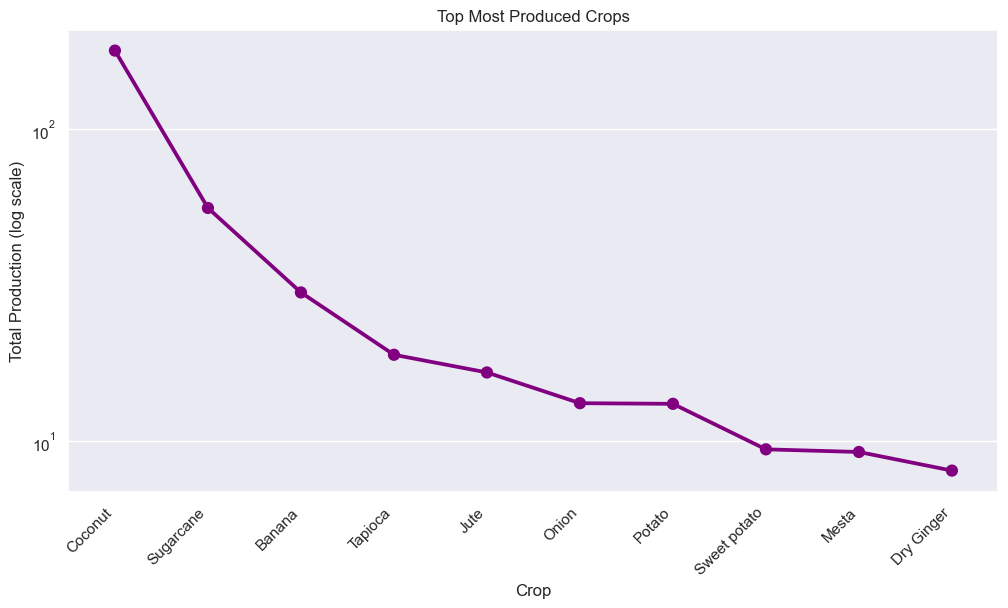

In [56]:
# Plotting the point plot with counts on top and log scale on y-axis
plt.figure(figsize=(12, 6))
pointplot = sns.pointplot(x='Crop', y='yield_per_hectare', data=top_crops, color='purple')
plt.yscale('log')  # Apply log scale on y-axis

plt.title('Top Most Produced Crops')
plt.xlabel('Crop')
plt.ylabel('Total Production (log scale)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

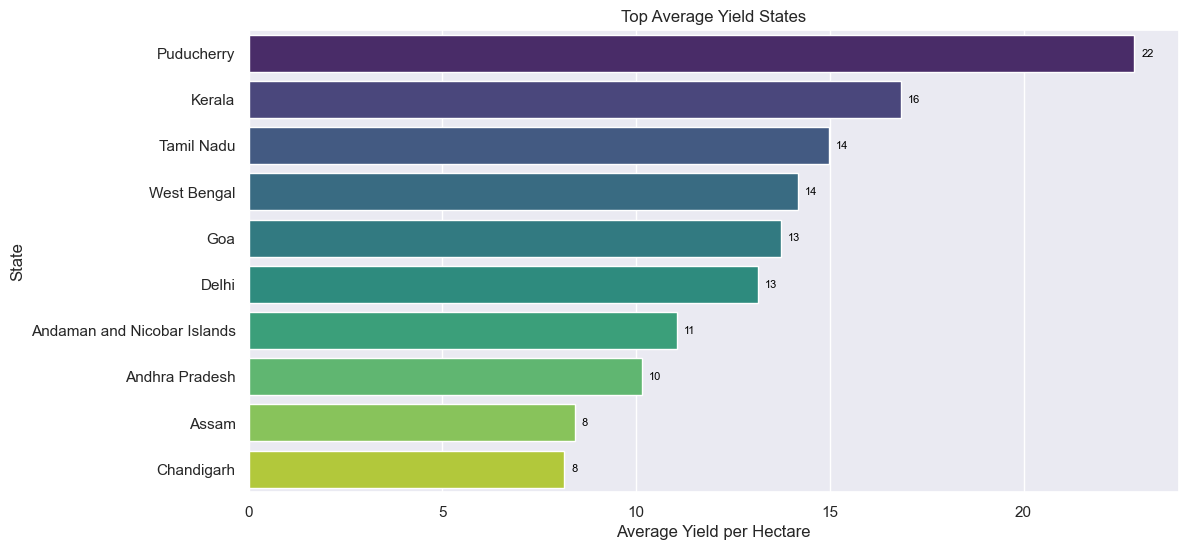

In [54]:
# Group data by 'State' and calculate average production for each state
state_avg_yield = new_df.groupby('State')['yield_per_hectare'].mean().reset_index()

# Sort the DataFrame by average production in descending order
top_avg_states = state_avg_yield.sort_values(by='yield_per_hectare', ascending=False).head(10)  # Displaying the top 10 states

# Plotting the horizontal bar chart for top average yielding states
plt.figure(figsize=(12, 6))
barplot_avg = sns.barplot(x='yield_per_hectare', y='State', data=top_avg_states, palette='viridis')

# Add counts on the right side of each bar
for p in barplot_avg.patches:
    barplot_avg.annotate(f'{int(p.get_width()):,}', (p.get_width(), p.get_y() + p.get_height() / 2.),
                         va='center', ha='left', xytext=(5, 0), textcoords='offset points', fontsize=8, color='black')

plt.title('Top Average Yield States')
plt.xlabel('Average Yield per Hectare')
plt.ylabel('State')
plt.show()


Top 5 Crops in terms of Yield (tonnes) for Kharif Season:
         Crop  yield_per_hectare
44  Sugarcane          58.046526
3      Banana          31.226289
21       Jute          17.291851
31      Onion          16.700714
47    Tapioca          13.939175




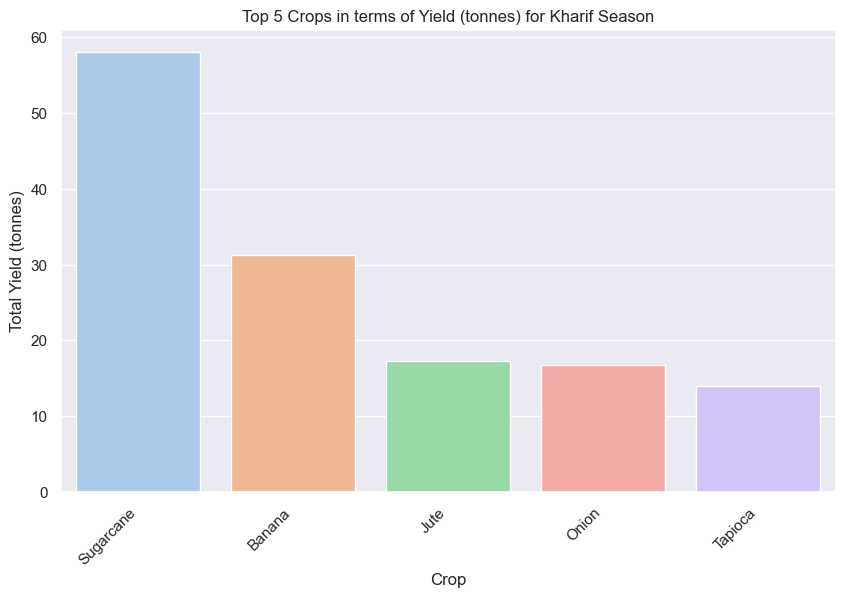

Top 5 Crops in terms of Yield (tonnes) for Whole Year Season:
            Crop  yield_per_hectare
9        Coconut         179.529138
40     Sugarcane          55.643549
3         Banana          28.203301
43       Tapioca          20.066544
11  Cotton(lint)          14.131633




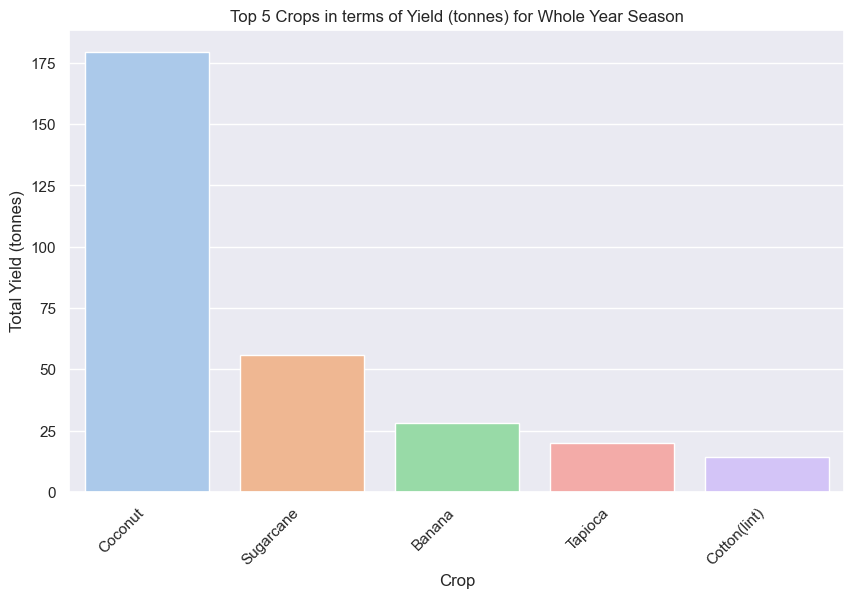

Top 5 Crops in terms of Yield (tonnes) for Rabi Season:
         Crop  yield_per_hectare
44  Sugarcane          30.907511
47    Tapioca          16.908388
35     Potato          16.119560
30      Onion          15.282808
25      Mesta          14.110641




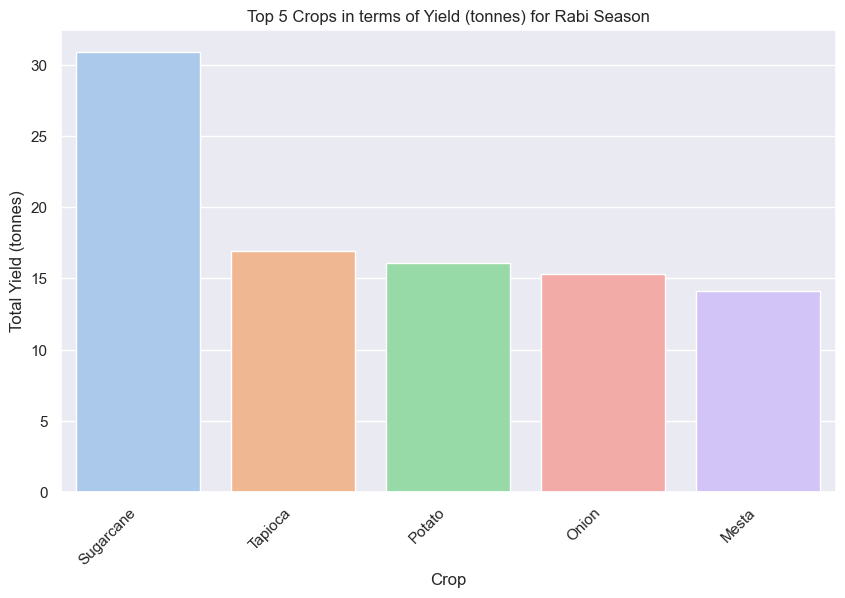

Top 5 Crops in terms of Yield (tonnes) for Autumn Season:
         Crop  yield_per_hectare
21  Sugarcane          14.710925
2      Banana          11.915119
9        Jute           8.541339
10      Maize           6.542337
23    Tapioca           6.092593




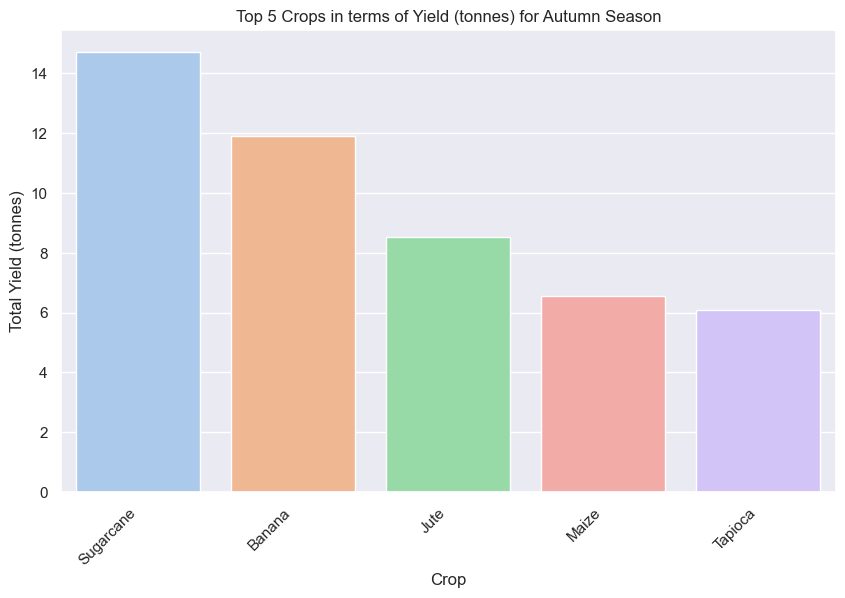

Top 5 Crops in terms of Yield (tonnes) for Summer Season:
         Crop  yield_per_hectare
3      Banana          44.522015
28  Sugarcane          24.827152
16      Onion          12.819496
21     Potato          12.794767
31    Tapioca           8.706469




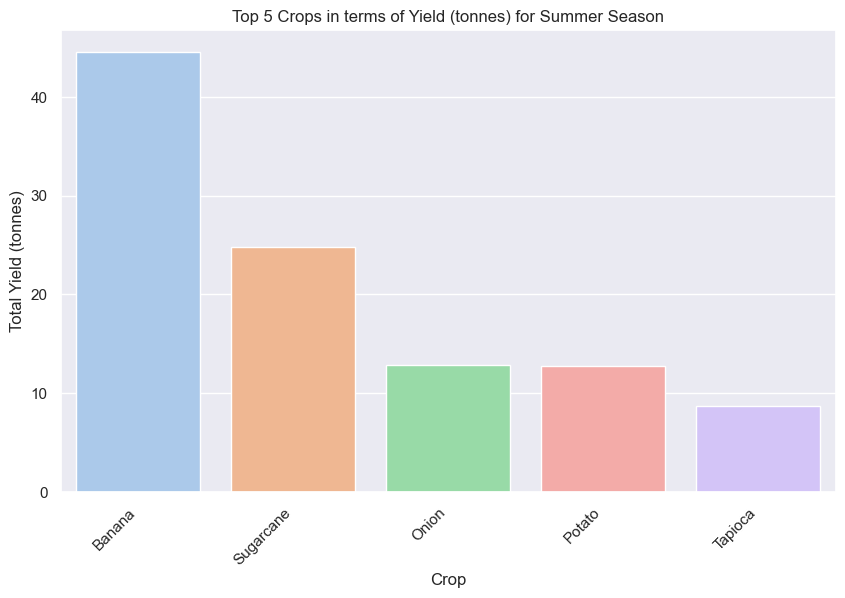

Top 5 Crops in terms of Yield (tonnes) for Winter Season:
            Crop  yield_per_hectare
21     Sugarcane          58.781087
1         Banana          13.895091
14        Potato          10.435910
0      Arhar/Tur           6.862852
23  Sweet potato           3.000000




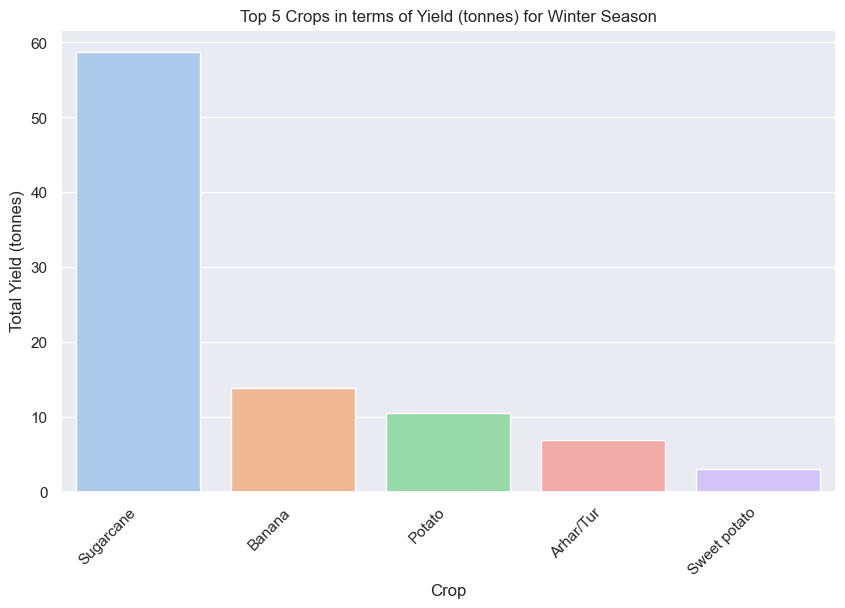

In [62]:
# Loop through each season and display the top 5 crops
for season in seasons:
    # Filter the DataFrame for the current season
    df_season = new_df[new_df['Season'] == season]

    # Group by crop and calculate the total yield in tonnes
    crop_yield_season = df_season.groupby('Crop')['yield_per_hectare'].mean().reset_index()

    # Sort in descending order to get the top yielding crops
    top_crops_season = crop_yield_season.sort_values(by='yield_per_hectare', ascending=False).head(5)

    # Display the top 5 crops for the current season
    print(f"Top 5 Crops in terms of Yield (tonnes) for {season} Season:")
    print(top_crops_season)
    print("\n" + "=" * 50 + "\n")  # Separating output for each season
    
    # Create a vertical bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Crop', y='yield_per_hectare', data=top_crops_season, palette='pastel')
    plt.title(f'Top 5 Crops in terms of Yield (tonnes) for {season} Season')
    plt.xlabel('Crop')
    plt.ylabel('Total Yield (tonnes)')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
    plt.show()

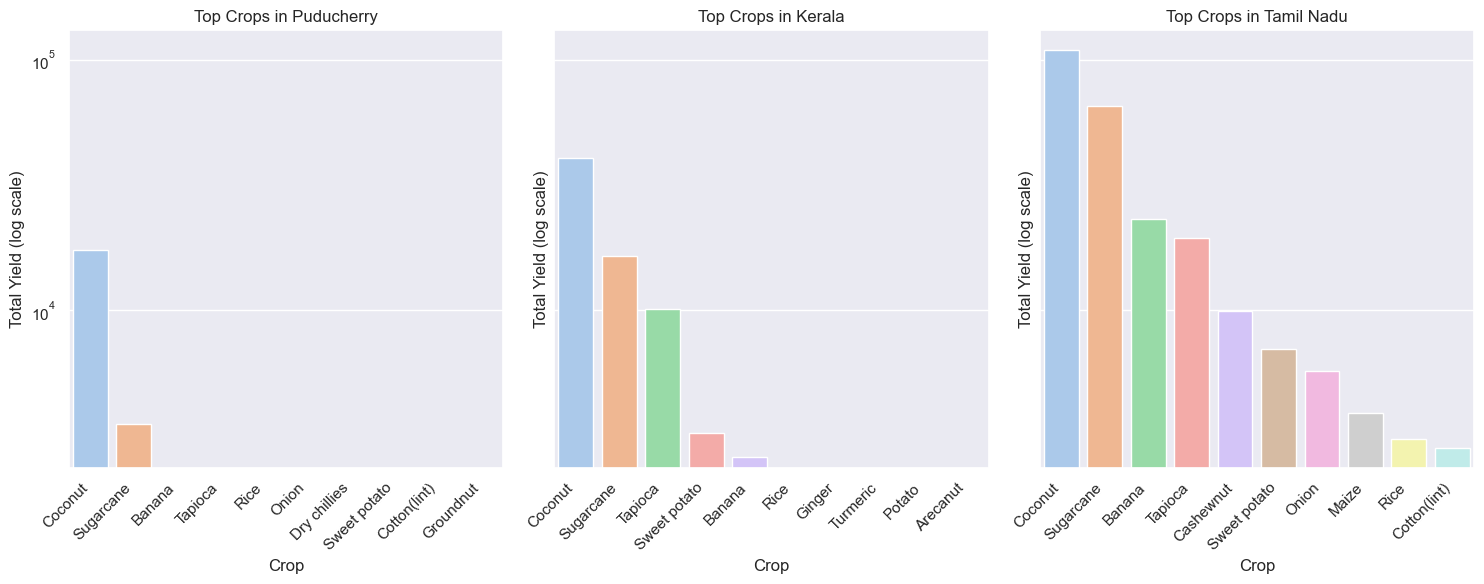

In [57]:
# Step 1: Identify the top 3 states based on total production
state_production = new_df.groupby('State')['yield_per_hectare'].mean().reset_index()
top_states = state_production.sort_values(by='yield_per_hectare', ascending=False).head(3)['State']

# Create subplots for each state
fig, axes = plt.subplots(1, len(top_states), figsize=(15, 6), sharey=True)

# Loop through each top state and create a separate plot
for i, state in enumerate(top_states):
    # Filter the dataset for the current state
    df_state = new_df[new_df['State'] == state]

    # Identify the top crops produced by the current state
    top_crops_state = df_state.groupby('Crop')['yield_per_hectare'].sum().reset_index().nlargest(10, 'yield_per_hectare')

    # Visualize the results using a vertical bar chart with log scale on y-axis and light colors
    sns.barplot(x='Crop', y='yield_per_hectare', data=top_crops_state, ax=axes[i], palette='pastel')
    axes[i].set_yscale('log')  # Set log scale on y-axis

    axes[i].set_title(f'Top Crops in {state}')
    axes[i].set_xlabel('Crop')
    axes[i].set_ylabel('Total Yield (log scale)')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')  # Rotate x-axis labels for better visibility

plt.tight_layout()
plt.show()

In [24]:
# List of South Indian states and Union Territories
south_indian_states = ['Andhra Pradesh', 'Telangana', 'Tamil Nadu', 'Karnataka', 'Kerala']
union_territories = ['Andaman and Nicobar Islands', 'Chandigarh', 'Dadra and Nagar Haveli', 'Daman and Diu', 'Delhi', 'Laddakh', 'Puducherry']

# Create masks to filter South Indian states and Union Territories
south_mask = new_df['State'].isin(south_indian_states)
union_territories_mask = new_df['State'].isin(union_territories)

# Apply the masks to get South Indian states and Union Territories DataFrames
south_indian_states_df = new_df[south_mask]
union_territories_df = new_df[union_territories_mask]
north_indian_states_df = new_df[~(south_mask | union_territories_mask)]

# Print the count and list of North Indian states after adding the remaining states
north_indian_states_count = north_indian_states_df['State'].nunique()
north_indian_states_list = north_indian_states_df['State'].unique()

print("Number of North Indian States:", north_indian_states_count)
print("List of North Indian States:")
print(north_indian_states_list)

Number of North Indian States: 24
List of North Indian States:
['Arunachal Pradesh' 'Assam' 'Bihar' 'Chhattisgarh' 'Goa' 'Gujarat'
 'Haryana' 'Himachal Pradesh' 'Jammu and Kashmir' 'Jharkhand'
 'Madhya Pradesh' 'Maharashtra' 'Manipur' 'Meghalaya' 'Mizoram' 'Nagaland'
 'Odisha' 'Punjab' 'Rajasthan' 'Sikkim' 'Tripura' 'Uttar Pradesh'
 'Uttarakhand' 'West Bengal']


In [63]:
# Group data by 'State' and calculate total production for each state in North India
north_india_production = north_indian_states_df.groupby('State')['yield_per_hectare'].mean().reset_index()

# Sort the DataFrame by production in descending order to get the top states
top_states_north_india = north_india_production.sort_values(by='yield_per_hectare', ascending=False)

# Print the top states in North India based on production
print("Top States in North India Based on Yield:")
print(top_states_north_india[['State', 'yield_per_hectare']])

Top States in North India Based on Yield:
                State  yield_per_hectare
23        West Bengal          14.186067
4                 Goa          13.748748
1               Assam           8.411203
6             Haryana           8.034349
17             Punjab           6.942172
5             Gujarat           5.704159
21      Uttar Pradesh           5.641859
12            Manipur           5.346048
20            Tripura           4.651057
11        Maharashtra           4.008622
2               Bihar           3.965729
16             Odisha           3.812353
10     Madhya Pradesh           3.792005
15           Nagaland           3.592530
22        Uttarakhand           3.489360
18          Rajasthan           3.472263
13          Meghalaya           3.364496
0   Arunachal Pradesh           3.333680
14            Mizoram           2.769099
9           Jharkhand           2.710815
7    Himachal Pradesh           2.100174
3        Chhattisgarh           2.086318
8   Jammu and K

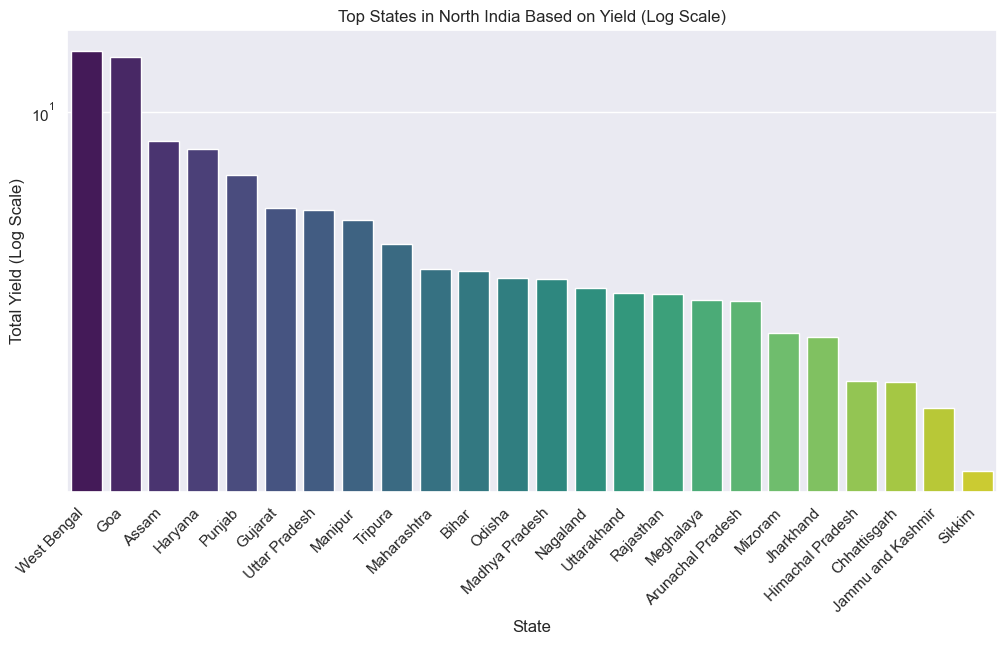

In [64]:
plt.figure(figsize=(12, 6))
sns.barplot(x='State', y='yield_per_hectare', data=top_states_north_india, palette='viridis', orient='v')

plt.yscale('log')  # Set y-axis to log scale
plt.title('Top States in North India Based on Yield (Log Scale)')
plt.xlabel('State')
plt.ylabel('Total Yield (Log Scale)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

In [60]:
# Group data by 'Crop' and calculate total production for each crop in North India
north_india_crop_production = north_indian_states_df.groupby('Crop')['yield_per_hectare'].mean().reset_index()

# Sort the DataFrame by production in descending order to get the top crops
top_crops_north_india = north_india_crop_production.sort_values(by='yield_per_hectare', ascending=False)

# Print the top produced crops in North India
print("Top Yield Crops in North India:")
print(top_crops_north_india[['Crop', 'yield_per_hectare']])

Top Yield Crops in North India:
                     Crop  yield_per_hectare
9                 Coconut         187.051438
46              Sugarcane          48.621687
3                  Banana          30.183584
21                   Jute          16.618283
37                 Potato          13.149041
31                  Onion          12.708033
26                  Mesta           9.269607
49                Tapioca           8.334034
48           Sweet potato           8.196582
15                 Ginger           5.410240
14                 Garlic           4.154389
11           Cotton(lint)           3.799697
51               Turmeric           3.259328
24                  Maize           2.388440
53                  Wheat           2.291275
50                Tobacco           2.078117
4                  Barley           1.942342
40                   Rice           1.885010
42               Sannhamp           1.582489
5            Black pepper           1.452183
13           Dry chilli

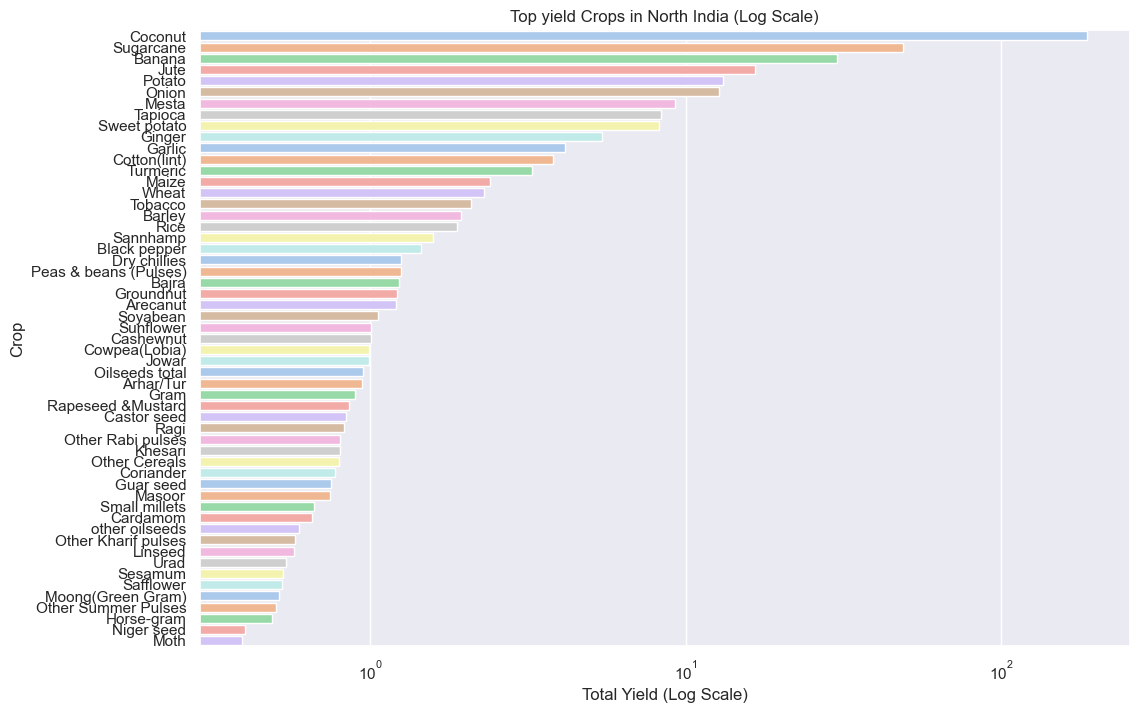

In [61]:
plt.figure(figsize=(12, 8))
sns.barplot(x='yield_per_hectare', y='Crop', data=top_crops_north_india, palette='pastel')

plt.xscale('log')  # Set x-axis to log scale
plt.title('Top yield Crops in North India (Log Scale)')
plt.xlabel('Total Yield (Log Scale)')
plt.ylabel('Crop')
plt.show()

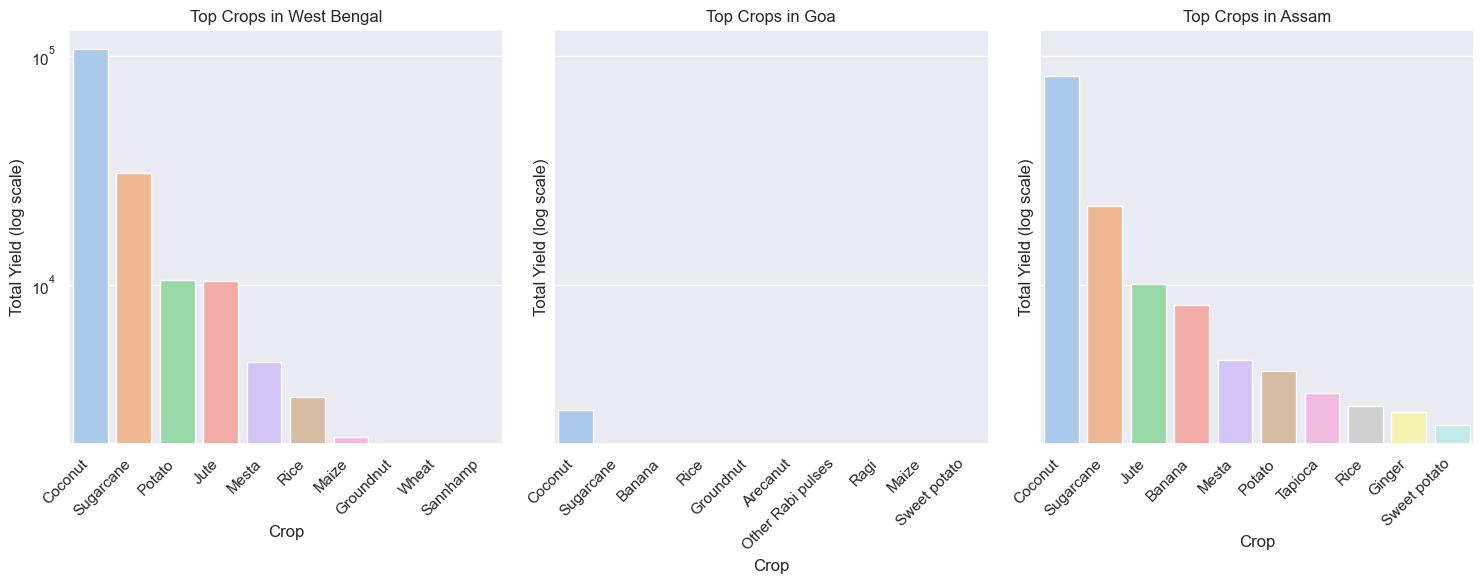

In [65]:
# Step 1: Identify the top 3 states in North India based on total production
north_india_production = north_indian_states_df.groupby('State')['yield_per_hectare'].mean().reset_index()
top_states_north_india = north_india_production.sort_values(by='yield_per_hectare', ascending=False).head(3)['State']

# Create subplots for each state
fig, axes = plt.subplots(1, len(top_states_north_india), figsize=(15, 6), sharey=True)

# Loop through each top state and create a separate plot
for i, state in enumerate(top_states_north_india):
    # Filter the dataset for the current state
    df_state = north_indian_states_df[north_indian_states_df['State'] == state]

    # Identify the top crops produced by the current state
    top_crops_state = df_state.groupby('Crop')['yield_per_hectare'].sum().reset_index().nlargest(10, 'yield_per_hectare')

    # Visualize the results using a vertical bar chart with log scale on y-axis and light colors
    sns.barplot(x='Crop', y='yield_per_hectare', data=top_crops_state, ax=axes[i], palette='pastel')
    axes[i].set_yscale('log')  # Set log scale on y-axis

    axes[i].set_title(f'Top Crops in {state}')
    axes[i].set_xlabel('Crop')
    axes[i].set_ylabel('Total Yield (log scale)')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')  # Rotate x-axis labels for better visibility

plt.tight_layout()
plt.show()


In [66]:
# Print unique crops and seasons for Union Territories
unique_crops = union_territories_df['Crop'].unique()
unique_seasons = union_territories_df['Season'].unique()

print("Unique Crops in Union Territories:")
print(unique_crops)

print("\nUnique Seasons in Union Territories:")
print(unique_seasons)

Unique Crops in Union Territories:
['Arecanut' 'Banana' 'Black pepper' 'Cashewnut' 'Coconut' 'Dry chillies'
 'Ginger' 'Other Kharif pulses' 'other oilseeds' 'Rice' 'Sugarcane'
 'Sweet potato' 'Maize' 'Masoor' 'Onion' 'Potato' 'Rapeseed &Mustard'
 'Sunflower' 'Urad' 'Wheat' 'Arhar/Tur' 'Gram' 'Jowar' 'Niger seed'
 'Other Rabi pulses' 'Ragi' 'Sannhamp' 'Small millets' 'Bajra' 'Barley'
 'Cotton(lint)' 'Coriander' 'Groundnut' 'Moong(Green Gram)' 'Tapioca'
 'Turmeric' 'Sesamum' 'Other Cereals' 'Dry Ginger' 'Safflower'
 'Cowpea(Lobia)' 'Oilseeds total' 'Tobacco' 'Other Summer Pulses']

Unique Seasons in Union Territories:
['Kharif' 'Whole Year' 'Rabi' 'Winter' 'Summer' 'Autumn']


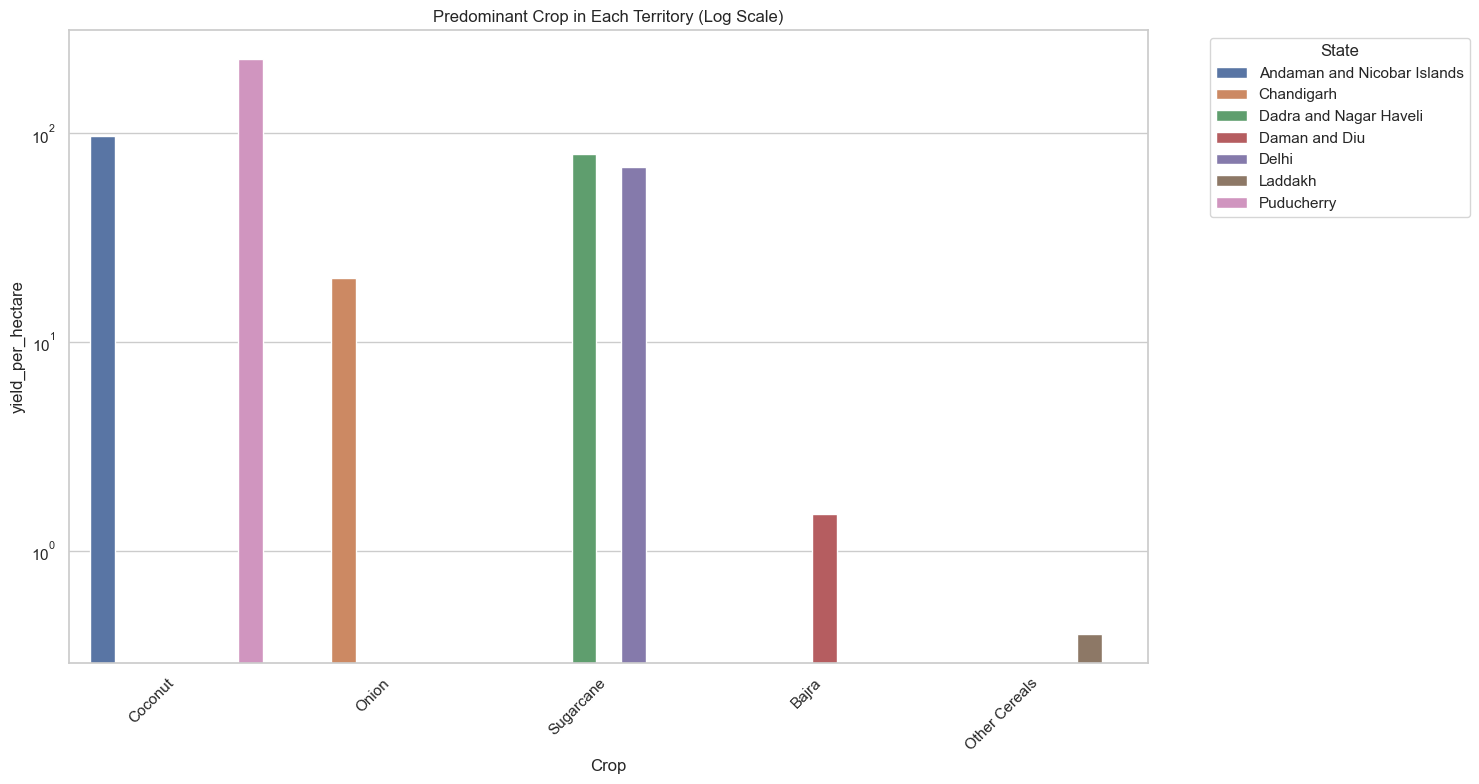

Count of Predominant Crops in Each Territory:
Coconut          2
Sugarcane        2
Onion            1
Bajra            1
Other Cereals    1
Name: Crop, dtype: int64


In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a mask to filter Union Territories
union_territories_mask = new_df['State'].isin(union_territories)

# Apply the mask to get Union Territories DataFrame
union_territories_df = new_df[union_territories_mask]

# Find the predominant crop in each territory
predominant_crops = union_territories_df.groupby(['State', 'Crop'])['yield_per_hectare'].mean().reset_index()
idx = predominant_crops.groupby('State')['yield_per_hectare'].idxmax()
predominant_crops = predominant_crops.loc[idx]

# Get the count of each predominant crop in each territory
crop_counts = predominant_crops['Crop'].value_counts()

# Set the style of the visualization
sns.set(style="whitegrid")

# Plot the graph
plt.figure(figsize=(15, 8))
sns.barplot(x='Crop', y='yield_per_hectare', hue='State', data=predominant_crops)
plt.yscale('log')  # Set log scale on y-axis
plt.title('Predominant Crop in Each Territory (Log Scale)')
plt.xlabel('Crop')
plt.ylabel('yield_per_hectare')
plt.xticks(rotation=45, ha='right')
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

# Print the count of each predominant crop in each territory
print("Count of Predominant Crops in Each Territory:")
print(crop_counts)


In [32]:
# Print the count and list of South Indian states
south_indian_states_count = south_indian_states_df['State'].nunique()
south_indian_states_list = south_indian_states_df['State'].unique()

print("Number of South Indian States:", south_indian_states_count)
print("List of South Indian States:")
print(south_indian_states_list)

Number of South Indian States: 5
List of South Indian States:
['Andhra Pradesh' 'Karnataka' 'Kerala' 'Tamil Nadu' 'Telangana']


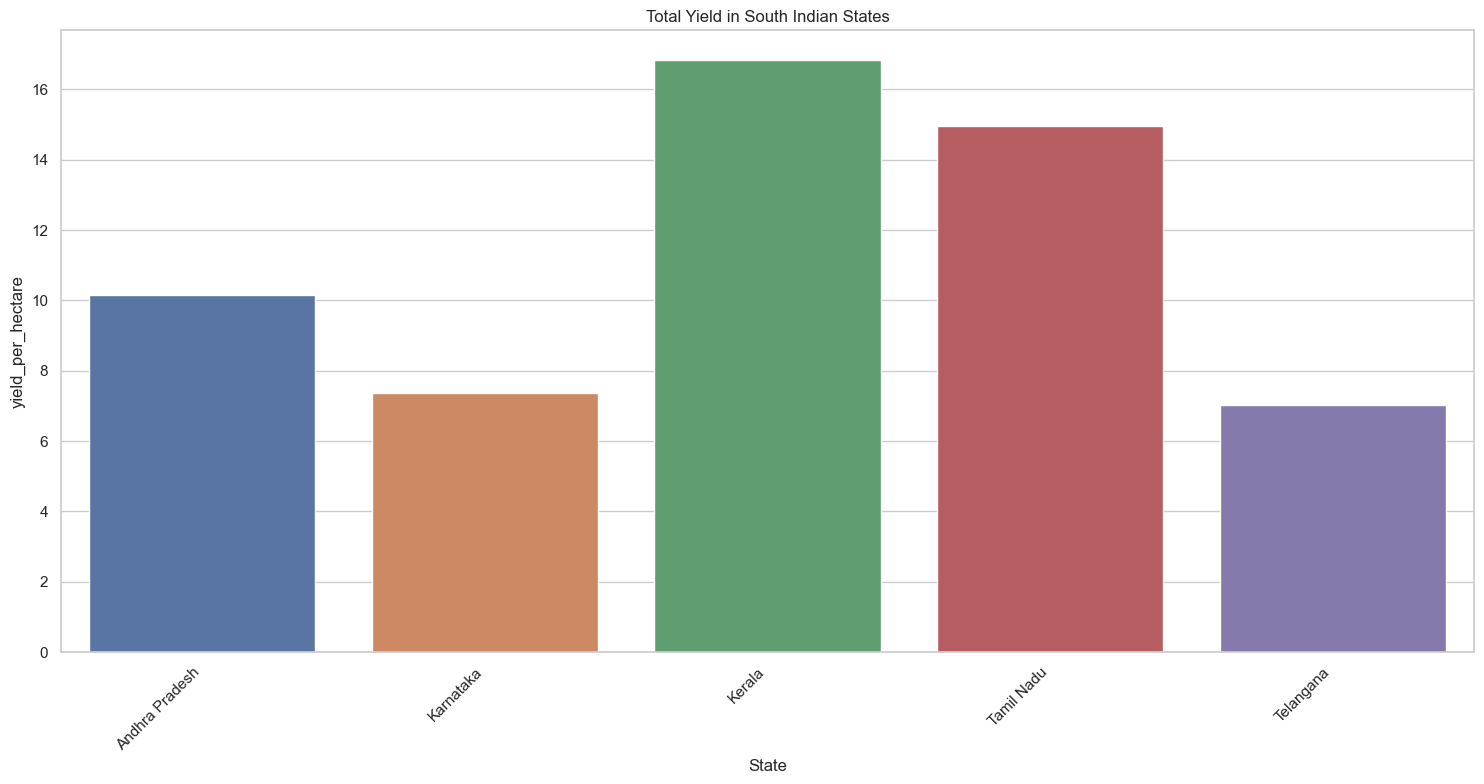

The topmost South Indian state is Kerala which has a production value of 16.83697988657439,
whereas the rest of the South Indian states have yield values as follows:
Andhra Pradesh: 10.149398480190694
Karnataka: 7.362617245829604
Tamil Nadu: 14.969388873388969
Telangana: 7.035298303213493


In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group data by 'State' and calculate total production for each state
state_production = south_indian_states_df.groupby('State')['yield_per_hectare'].mean().reset_index()

# Find the topmost production state
top_production_state = state_production.loc[state_production['yield_per_hectare'].idxmax()]

# Set the style of the visualization
sns.set(style="whitegrid")

# Plot the graph
plt.figure(figsize=(15, 8))
sns.barplot(x='State', y='yield_per_hectare', data=state_production)
plt.title('Total Yield in South Indian States')
plt.xlabel('State')
plt.ylabel('yield_per_hectare')

# Show the plot
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print the information about the topmost production state and the rest of the states
print(f"The topmost South Indian state is {top_production_state['State']} which has a production value of {top_production_state['yield_per_hectare']},")
print(f"whereas the rest of the South Indian states have yield values as follows:")
for index, row in state_production.iterrows():
    if row['State'] != top_production_state['State']:
        print(f"{row['State']}: {row['yield_per_hectare']}")


In [71]:
# Filter data for the state of kerala
TamilNadu_districts = south_indian_states_df[south_indian_states_df['State'] == 'Kerala']['District'].unique()

# Print the unique districts in kerala
print("Unique Districts in Kerala:")
print(TamilNadu_districts)

Unique Districts in Kerala:
['ALAPPUZHA' 'ERNAKULAM' 'IDUKKI' 'KANNUR' 'KASARAGOD' 'KOLLAM' 'KOTTAYAM'
 'KOZHIKODE' 'MALAPPURAM' 'PALAKKAD' 'PATHANAMTHITTA' 'THIRUVANANTHAPURAM'
 'THRISSUR' 'WAYANAD']


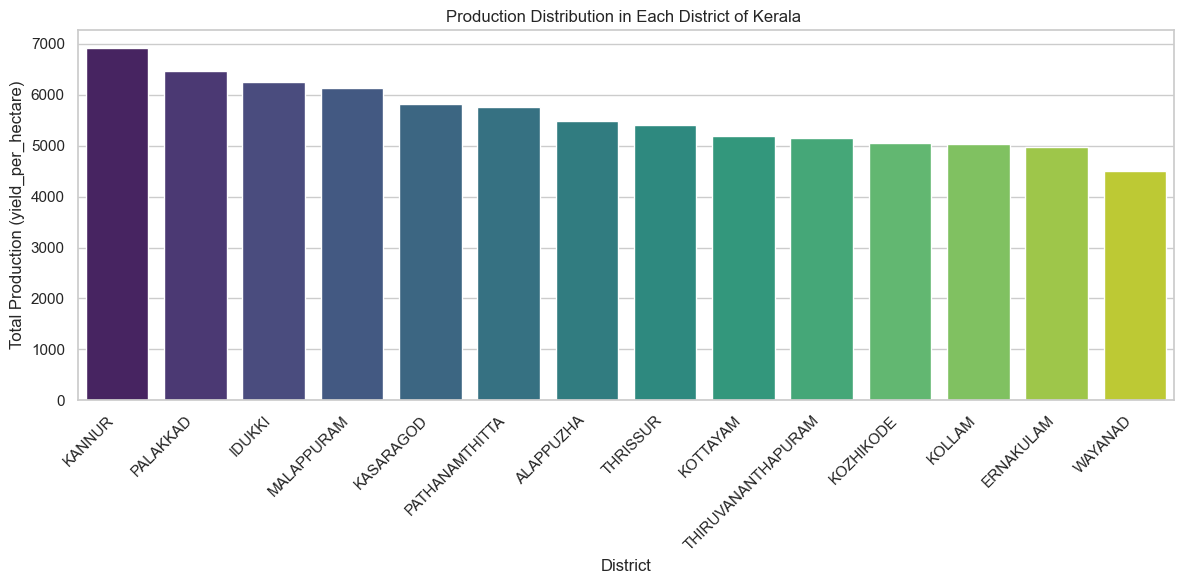

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns


# Filter data for the state of Tamil Nadu
Kerala_data = south_indian_states_df[south_indian_states_df['State'] == 'Kerala']

# Calculate production sum for each district
production_by_district = Kerala_data.groupby('District')['yield_per_hectare'].sum().sort_values(ascending=False)

# Set the style of the visualization
sns.set(style="whitegrid")

# Create a bar plot using seaborn
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x=production_by_district.index, y=production_by_district, palette="viridis")
bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Production Distribution in Each District of Kerala ')
plt.xlabel('District')
plt.ylabel('Total Production (yield_per_hectare)')
plt.tight_layout()
plt.show()


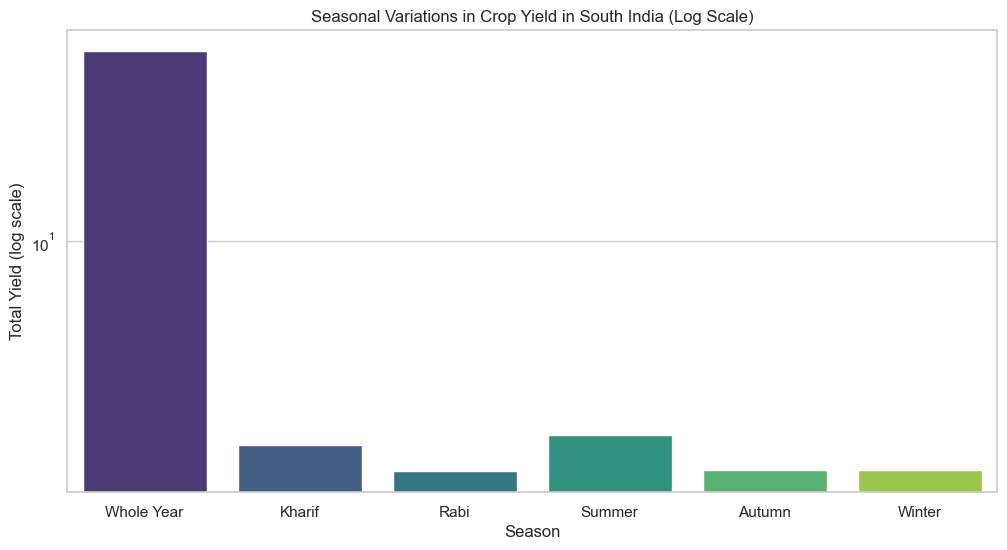

In [73]:
# Set the style of the visualization
sns.set(style="whitegrid")

# Plot a bar chart to show total production for each season in South India
plt.figure(figsize=(12, 6))
sns.barplot(x='Season', y='yield_per_hectare', data=south_indian_states_df, palette='viridis', ci=None)
plt.yscale('log')  # Apply log scale on y-axis
plt.title('Seasonal Variations in Crop Yield in South India (Log Scale)')
plt.xlabel('Season')
plt.ylabel('Total Yield (log scale)')
plt.show()

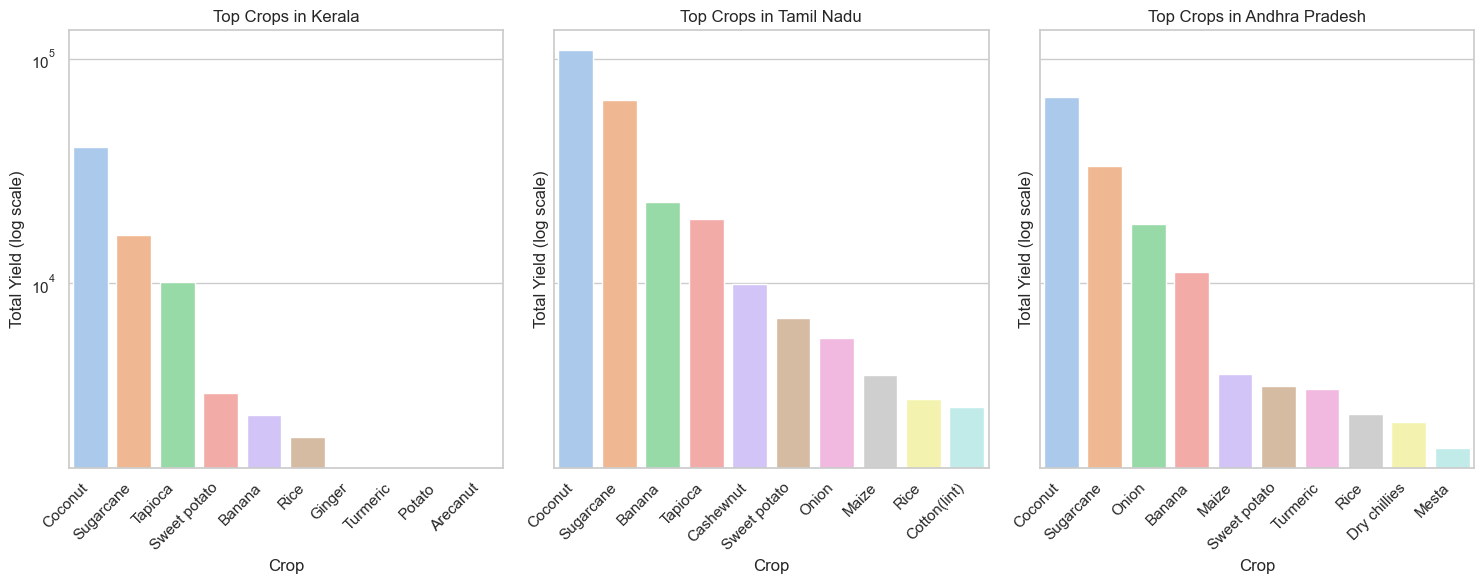

In [74]:
# Step 1: Identify the top 3 states in South India based on total production
south_india_production = south_indian_states_df.groupby('State')['yield_per_hectare'].mean().reset_index()
top_states_south_india = south_india_production.sort_values(by='yield_per_hectare', ascending=False).head(3)['State']

# Create subplots for each state
fig, axes = plt.subplots(1, len(top_states_south_india), figsize=(15, 6), sharey=True)

# Loop through each top state and create a separate plot
for i, state in enumerate(top_states_south_india):
    # Filter the dataset for the current state
    df_state = south_indian_states_df[south_indian_states_df['State'] == state]

    # Identify the top crops produced by the current state
    top_crops_state = df_state.groupby('Crop')['yield_per_hectare'].sum().reset_index().nlargest(10, 'yield_per_hectare')

    # Visualize the results using a vertical bar chart with log scale on y-axis and light colors
    sns.barplot(x='Crop', y='yield_per_hectare', data=top_crops_state, ax=axes[i], palette='pastel')
    axes[i].set_yscale('log')  # Set log scale on y-axis

    axes[i].set_title(f'Top Crops in {state}')
    axes[i].set_xlabel('Crop')
    axes[i].set_ylabel('Total Yield (log scale)')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')  # Rotate x-axis labels for better visibility

plt.tight_layout()
plt.show()


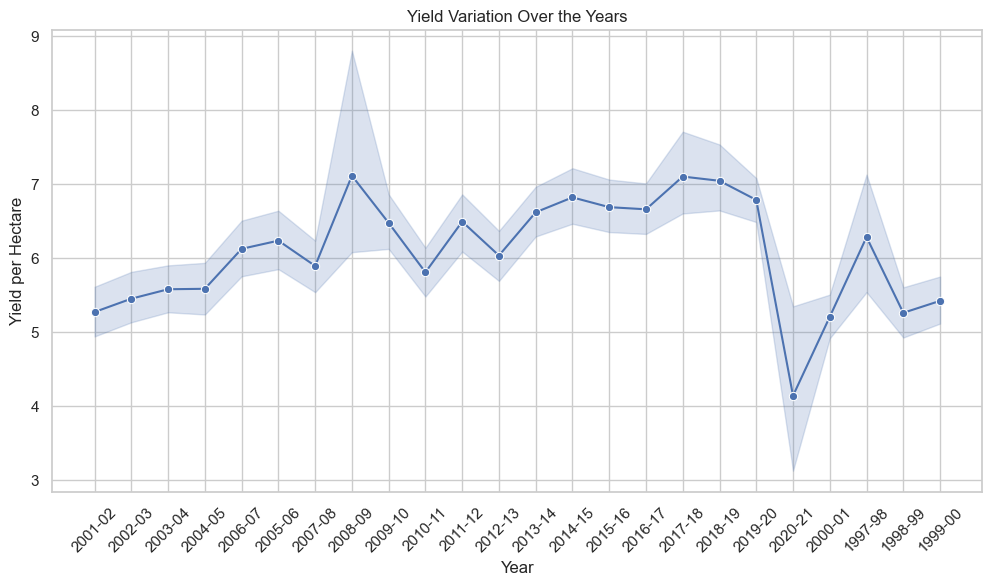

In [49]:
# Create a line plot for yield variation over the years
plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='yield_per_hectare', data=new_df, marker='o', color='b')

plt.title('Yield Variation Over the Years')
plt.xlabel('Year')
plt.ylabel('Yield per Hectare')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(True)
plt.show()

Top 5 Crops in terms of Yield (tonnes) for Kharif Season in Telangana:
              Crop  yield_per_hectare
28       Sugarcane          77.769276
2           Banana          56.470241
19           Onion          17.024751
15           Mesta          14.423016
35  other oilseeds          13.893159


Bottom 5 Crops in terms of Yield (tonnes) for Kharif Season in Telangana:
                   Crop  yield_per_hectare
25              Sesamum           0.177551
17           Niger seed           0.300000
3             Cashewnut           0.367774
20  Other Kharif pulses           0.440281
12           Horse-gram           0.624418




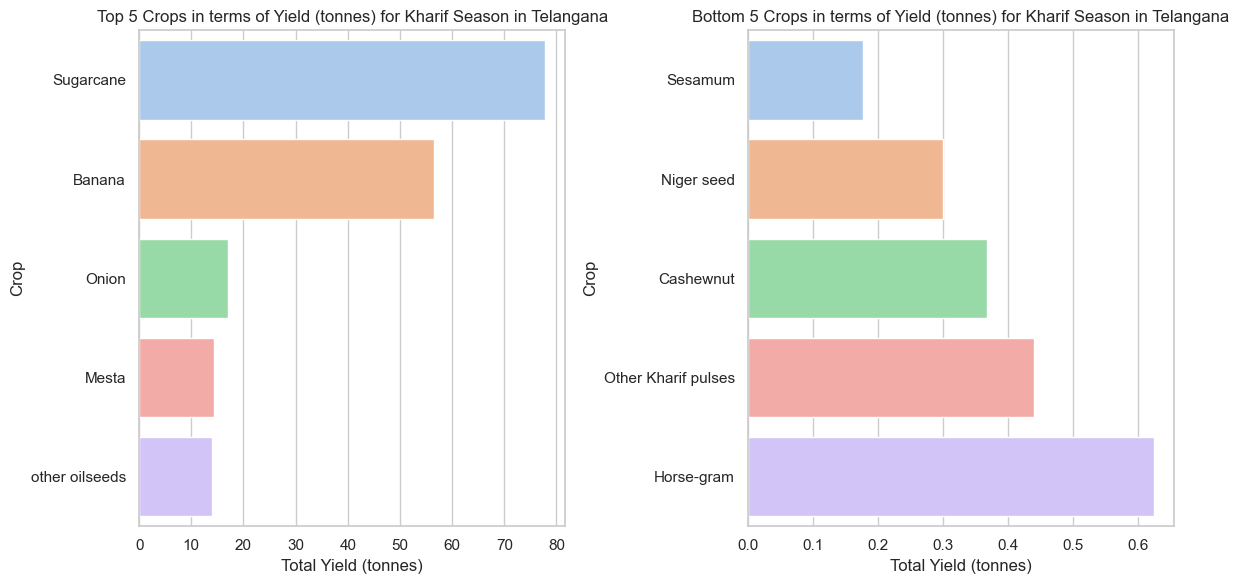

Top 5 Crops in terms of Yield (tonnes) for Whole Year Season in Telangana:
           Crop  yield_per_hectare
1       Coconut         373.590000
0        Banana          31.149914
3        Potato          14.708952
4  Sweet potato           7.568421
2     Coriander           0.470246


Bottom 5 Crops in terms of Yield (tonnes) for Whole Year Season in Telangana:
           Crop  yield_per_hectare
2     Coriander           0.470246
4  Sweet potato           7.568421
3        Potato          14.708952
0        Banana          31.149914
1       Coconut         373.590000




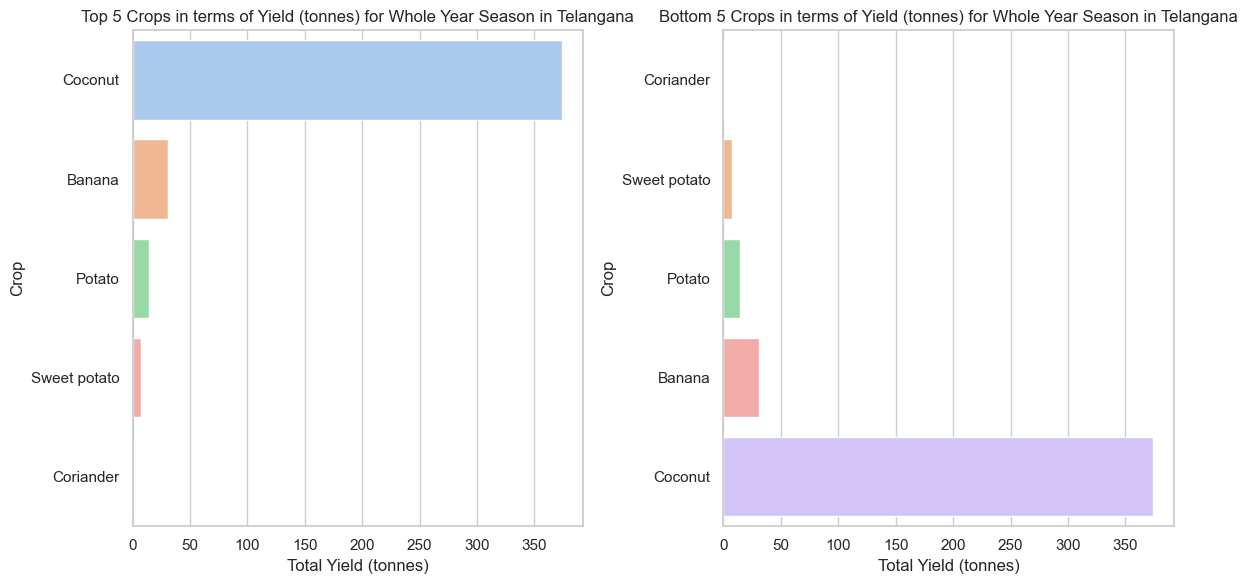

Top 5 Crops in terms of Yield (tonnes) for Rabi Season in Telangana:
            Crop  yield_per_hectare
29     Sugarcane          80.000000
19         Onion          31.247598
15         Mesta          13.825000
21        Potato          12.681976
31  Sweet potato          10.383133


Bottom 5 Crops in terms of Yield (tonnes) for Rabi Season in Telangana:
          Crop  yield_per_hectare
17  Niger seed           0.400000
14      Masoor           0.416601
12     Linseed           0.451646
10  Horse-gram           0.582434
26     Sesamum           0.619164




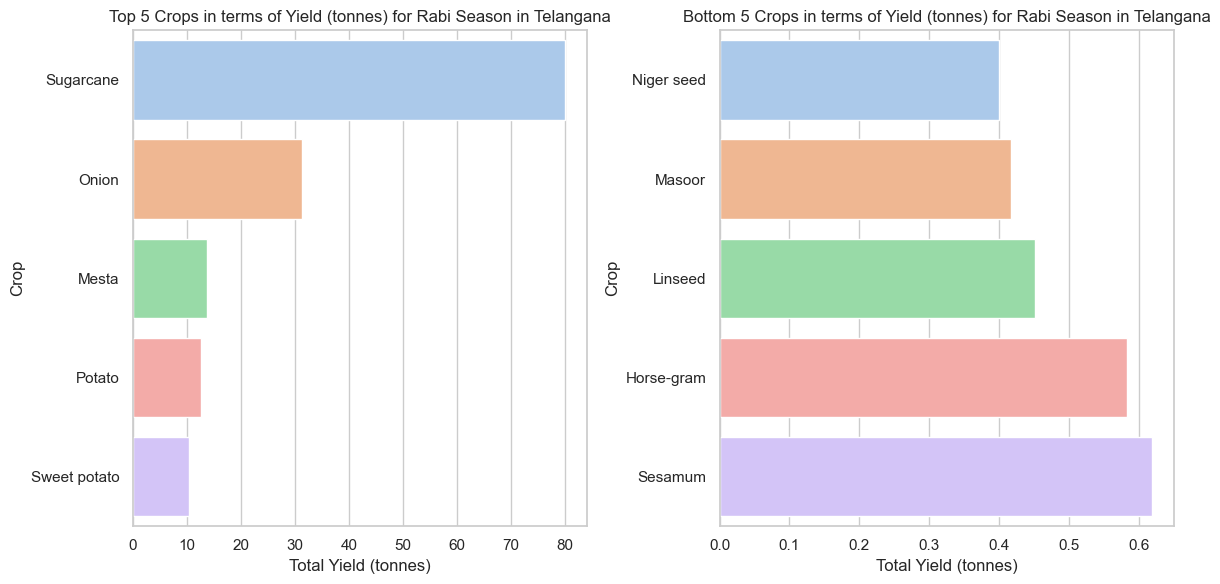

Top 5 Crops in terms of Yield (tonnes) for Autumn Season in Telangana:
Empty DataFrame
Columns: [Crop, yield_per_hectare]
Index: []


Bottom 5 Crops in terms of Yield (tonnes) for Autumn Season in Telangana:
Empty DataFrame
Columns: [Crop, yield_per_hectare]
Index: []


No data available for creating bar plots in Autumn Season in Telangana.

Top 5 Crops in terms of Yield (tonnes) for Summer Season in Telangana:
Empty DataFrame
Columns: [Crop, yield_per_hectare]
Index: []


Bottom 5 Crops in terms of Yield (tonnes) for Summer Season in Telangana:
Empty DataFrame
Columns: [Crop, yield_per_hectare]
Index: []


No data available for creating bar plots in Summer Season in Telangana.

Top 5 Crops in terms of Yield (tonnes) for Winter Season in Telangana:
Empty DataFrame
Columns: [Crop, yield_per_hectare]
Index: []


Bottom 5 Crops in terms of Yield (tonnes) for Winter Season in Telangana:
Empty DataFrame
Columns: [Crop, yield_per_hectare]
Index: []


No data available for creating bar plots 

In [75]:
# Get unique seasons in the DataFrame
seasons = new_df['Season'].unique()

# Loop through each season and display the top 5 and bottom 5 crops for Telangana
for season in seasons:
    # Filter the DataFrame for the current season and Telangana state
    df_season_telangana = new_df[(new_df['Season'] == season) & (new_df['State'] == 'Telangana')]

    # Group by crop and calculate the total yield in tonnes for Telangana
    crop_yield_season_telangana = df_season_telangana.groupby('Crop')['yield_per_hectare'].mean().reset_index()

    # Sort in descending order to get the top yielding crops for Telangana
    top_crops_telangana = crop_yield_season_telangana.sort_values(by='yield_per_hectare', ascending=False).head(5)
    
    # Sort in ascending order to get the bottom yielding crops for Telangana
    bottom_crops_telangana = crop_yield_season_telangana.sort_values(by='yield_per_hectare').head(5)

    # Display the top 5 crops for Telangana in terms of yield
    print(f"Top 5 Crops in terms of Yield (tonnes) for {season} Season in Telangana:")
    print(top_crops_telangana)
    print("\n" + "=" * 50 + "\n")  # Separating output for each season

    # Display the bottom 5 crops for Telangana in terms of yield
    print(f"Bottom 5 Crops in terms of Yield (tonnes) for {season} Season in Telangana:")
    print(bottom_crops_telangana)
    print("\n" + "=" * 50 + "\n")  # Separating output for each season
    
    # Check if top_crops_telangana is not empty before creating bar plots
    if not top_crops_telangana.empty:
        # Create bar plots for top and bottom crops for Telangana
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        sns.barplot(x='yield_per_hectare', y='Crop', data=top_crops_telangana, palette='pastel')
        plt.title(f'Top 5 Crops in terms of Yield (tonnes) for {season} Season in Telangana')
        plt.xlabel('Total Yield (tonnes)')
        plt.ylabel('Crop')

        plt.subplot(1, 2, 2)
        sns.barplot(x='yield_per_hectare', y='Crop', data=bottom_crops_telangana, palette='pastel')
        plt.title(f'Bottom 5 Crops in terms of Yield (tonnes) for {season} Season in Telangana')
        plt.xlabel('Total Yield (tonnes)')
        plt.ylabel('Crop')

        plt.tight_layout()
        plt.show()
    else:
        print(f"No data available for creating bar plots in {season} Season in Telangana.\n")

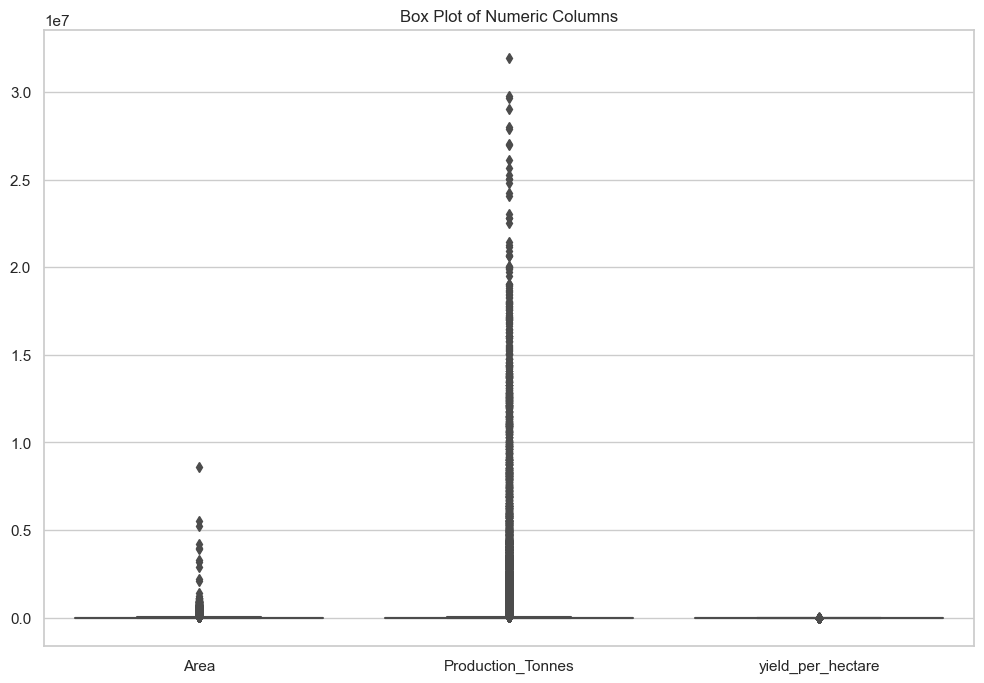

In [76]:
# Select numeric columns for box plot
numeric_columns = new_df.select_dtypes(include=['float64', 'int64']).columns

# Create box plots for each numeric column
plt.figure(figsize=(12, 8))
sns.boxplot(data=new_df[numeric_columns])
plt.title('Box Plot of Numeric Columns')
plt.show()

In [77]:
Q1 = new_df.quantile(0.25)
Q3 = new_df.quantile(0.75)
IQR = Q3 - Q1
df_no_outliers = new_df[~((new_df < (Q1 - 1.5 * IQR)) | (new_df > (Q3 + 1.5 * IQR))).any(axis=1)]

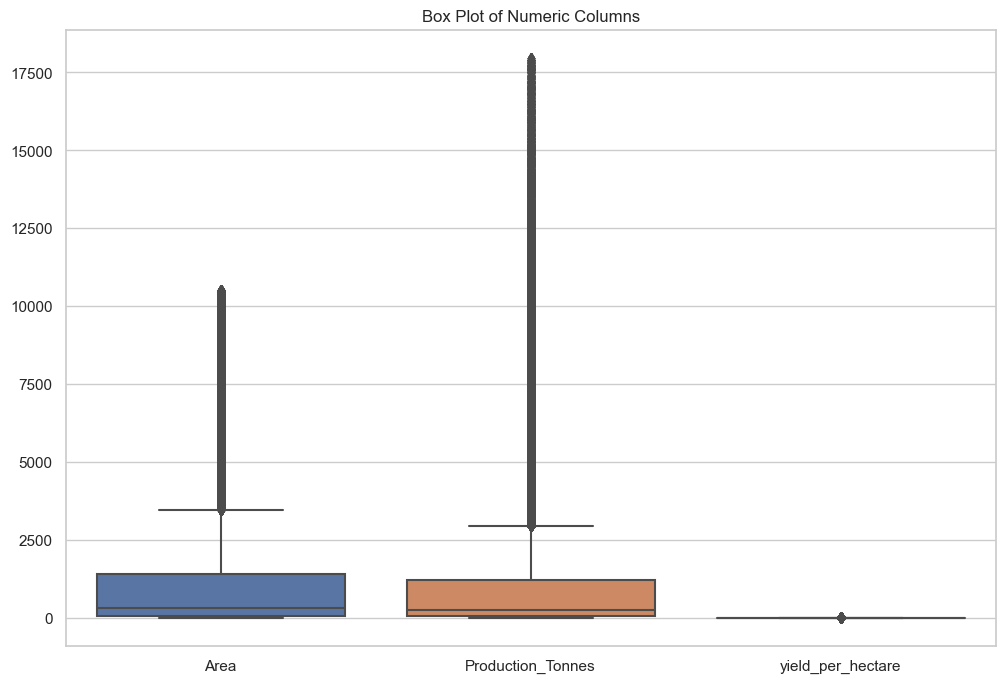

In [78]:
# Select numeric columns for box plot
numeric_columns = df_no_outliers.select_dtypes(include=['float64', 'int64']).columns

# Create box plots for each numeric column
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_no_outliers[numeric_columns])
plt.title('Box Plot of Numeric Columns')
plt.show()

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

# Select relevant features
features = ['State', 'District', 'Area', 'Season', 'yield_per_hectare']

# Encode categorical features
le_state = LabelEncoder()
le_district = LabelEncoder()
le_season = LabelEncoder()
le_yield = LabelEncoder()

df_no_outliers['State'] = le_state.fit_transform(df_no_outliers['State'])
df_no_outliers['District'] = le_district.fit_transform(df_no_outliers['District'])
df_no_outliers['Season'] = le_season.fit_transform(df_no_outliers['Season'])
df_no_outliers['yield_per_hectare'] = le_yield.fit_transform(df_no_outliers['yield_per_hectare'])

X = df_no_outliers[features]
y = df_no_outliers['Crop']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest classifier
model = RandomForestClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Print classification report
print("Classification Report:\n", classification_report(y_test, predictions))

# Print accuracy score
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')



Classification Report:
                        precision    recall  f1-score   support

             Arecanut       0.79      0.71      0.75       340
            Arhar/Tur       0.49      0.51      0.50      1855
                Bajra       0.48      0.45      0.46      1115
               Banana       0.65      0.43      0.52        35
               Barley       0.72      0.73      0.72      1060
         Black pepper       0.82      0.81      0.81       252
             Cardamom       0.93      0.90      0.91        99
            Cashewnut       0.68      0.69      0.68       264
          Castor seed       0.46      0.45      0.45       797
              Coconut       1.00      0.67      0.80         3
            Coriander       0.64      0.74      0.68       956
         Cotton(lint)       0.68      0.59      0.63       676
        Cowpea(Lobia)       0.40      0.37      0.39       327
         Dry chillies       0.61      0.67      0.64      1657
               Garlic       0.

Developing a predictive model for crop yield based solely on general features (area, production, state, district) was challenging due to the diverse fertility requirements of different crops.

Also, Crop yield can be influenced by temporal factors such as weather conditions, which can vary from year to year. Incorporating these dynamics into the model and accounting for seasonality may present challenges.


## Conclusion:

Top Yielded Crops: Coconut and sugarcane are the top yielded crops in India, contributing significantly to overall agricultural production.

Impact of COVID-19: The yield decline observed in 2020-21 is attributed to the impact of COVID-19. This could be due to disruptions in the supply chain, labor shortages, or other pandemic-related challenges affecting agriculture.

Seasonal Variation: Sugarcane consistently dominates in yield across different seasons - Kharif, Rabi, Autumn, and Winter.

Regional Disparities of South India: Kerala has the highest average yield in South India, followed by Tamil Nadu and Puducherry.

North India: West Bengal is the top state, especially excelling in coconut production.

Union Territories: Coconut and sugarcane are major crops in union territories. In south India, Telangana faces challenges with lower yields, especially producing only in rabi, kharif, and the whole year.
